## Feature selection and Feature Engineering¶

**Baseline Model:**
1. Feature Importance
2. Feature Selection

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import os
from timeit import default_timer as timer # For measuring the performance of the code
from __future__ import division 

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [3]:
filename_train = '../train_2016_v2.csv'

filename_properties = '../properties_2016.csv'

filename_sample = '../sample_submission.csv'

# importing the datasets
train_data_df = pd.read_csv(filename_train ,quotechar='"',skipinitialspace=True).dropna(how='all')
properties_data_df = pd.read_csv(filename_properties ,quotechar='"',skipinitialspace=True).dropna(how='all')
filename_sample_df = pd.read_csv(filename_sample ,quotechar='"',skipinitialspace=True).dropna(how='all') 

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/io/parsers.py:1150: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
df_f1 = pd.merge(train_data_df, properties_data_df, how='left', on=['parcelid'])

In [5]:
col_dtypes = df_f1.dtypes.reset_index()
col = ['colnames', 'datatypes'] 
col_dtypes.columns =col

col_dtypes_num = col_dtypes[(col_dtypes.datatypes == 'int64') | (col_dtypes.datatypes == 'float64')]
df2 = df_f1[list(col_dtypes_num.colnames)]
df2.head()

,parcelid,logerror,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,1,NaN,NaN,2.0,3,NaN,4,2.0,...,NaN,1959,NaN,122754,360170,2015,237416,6735.88,NaN,6.037107e+13
1,14366692,-0.1684,NaN,NaN,NaN,3.5,4,NaN,NaN,3.5,...,NaN,2014,NaN,346458,585529,2015,239071,10153.02,NaN,NaN
2,12098116,-0.0040,1,NaN,NaN,3.0,2,NaN,4,3.0,...,NaN,1940,NaN,61994,119906,2015,57912,11484.48,NaN,6.037464e+13
3,12643413,0.0218,1,NaN,NaN,2.0,2,NaN,4,2.0,...,NaN,1987,NaN,171518,244880,2015,73362,3048.74,NaN,6.037296e+13
4,14432541,-0.0050,NaN,NaN,NaN,2.5,4,NaN,NaN,2.5,...,NaN,1981,2,169574,434551,2015,264977,5488.96,NaN,6.059042e+13


In [6]:
# Getting the percentage of missing values for each of the cloumns
df_null = df2.isnull().sum() /df2.index.max()
df_null = df_null.reset_index()
df_null.columns = ['colnames', 'pct_null']
df_null_sorted = df_null.sort('pct_null')
less_null_cols = list(df_null_sorted[df_null_sorted.pct_null<=0.8].colnames)


from sklearn import preprocessing

df3 = df2[less_null_cols]

imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df3)
missing_imputed = imp.transform(df3)
df_missing_imputed = pd.DataFrame(missing_imputed, columns=df3.columns)


df_corr = df_missing_imputed.corrwith(df_missing_imputed.logerror).reset_index()
df_corr.columns = ['colnames', 'correlation']
df_corr_sorted = df_corr.sort('correlation')
df_corr_sorted = df_corr_sorted.dropna(how='any')
#df_corr_sorted = df_corr_sorted[(df_corr_sorted['colnames'] != 'logerror')]

df4 = df_corr_sorted[(df_corr_sorted.correlation >= 0.01) | (df_corr_sorted.correlation <= -0.01)]

## Re-do the missing value imputation
#df3[list(df4.colnames)]
df_f = df_missing_imputed.drop(['parcelid'], axis=1)
df_f.head()

,longitude,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,latitude,fips,bedroomcnt,bathroomcnt,assessmentyear,...,finishedsquarefeet12,lotsizesquarefeet,unitcnt,buildingqualitytypeid,heatingorsystemtypeid,regionidneighborhood,garagetotalsqft,garagecarcnt,airconditioningtypeid,numberofstories
0,-118488536,261,60371066.461001,3101,0,34280990,6037,3,2.0,2015,...,1684,7528,1.000000,4.000000,2.000000,31817.000000,345.521228,1.812005,1.000000,1.440739
1,-117677556,261,60590524.222024,1286,0,33668120,6059,4,3.5,2015,...,2263,3643,1.110414,5.565407,3.926979,190646.540237,468.000000,2.000000,1.816372,1.440739
2,-118175032,261,60374638.003004,3101,0,34136312,6037,2,3.0,2015,...,2217,11423,1.000000,4.000000,2.000000,275411.000000,345.521228,1.812005,1.000000,1.440739
3,-118309000,266,60372963.002002,3101,0,33755800,6037,2,2.0,2015,...,839,70859,1.000000,4.000000,2.000000,54300.000000,345.521228,1.812005,1.000000,1.440739
4,-117700234,261,60590423.381006,1286,8,33485643,6059,4,2.5,2015,...,2283,6000,1.110414,5.565407,3.926979,190646.540237,598.000000,2.000000,1.816372,2.000000


In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation, metrics


# Let's do the variable importance thest and randomtreeRegressor
X = df_f.drop(['logerror'], axis=1)
y = df_f.logerror

offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]


# Fit regression model
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
#Predict training set:
#dtrain_predictions = clf.predict(X_train)
#dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]


mse = mean_squared_error(y_test, clf.predict(X_test))

#Print model report:
print "\nModel Report"
print "Accuracy on the train dataset: %.4g" % clf.score(X_train, y_train)
print "Accuracy on the test dataset: %.4g" % clf.score(X_test, y_test)

print("MSE: %.4f" % mse)


Model Report
Accuracy on the train dataset: 0.5059
Accuracy on the test dataset: -0.05183
MSE: 0.0234


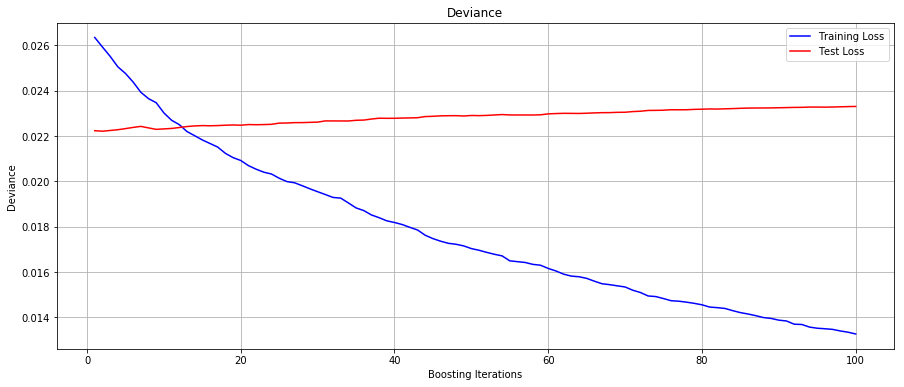

In [35]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(15, 6))
#plt.subplot(211)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Loss')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Loss')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.grid()

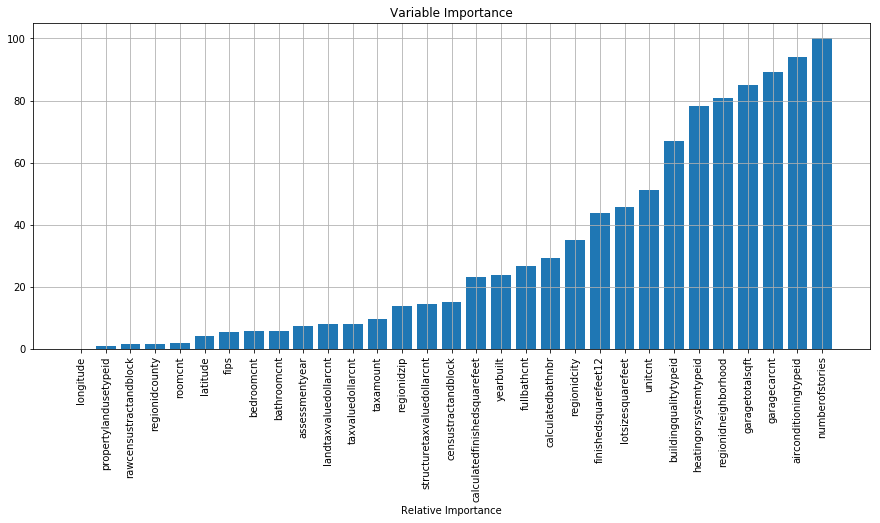

In [34]:
# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance) #Returns the indices that would sort an array.
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(15, 6))
#plt.subplot(212)
plt.bar(pos, feature_importance[sorted_idx], align='center')
plt.xticks(pos, X.columns, rotation='vertical')
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.grid()

plt.show()

### Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1. Take the whole dataset consisting of d-dimensional samples ignoring the class labels
2. Compute the d-dimensional mean vector (i.e., the means for every dimension of the whole dataset)
3. Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set
4. Compute eigenvectors $(e_1,e_2,...,e_d)$ and corresponding eigenvalues $(λ_1,λ_2,...,λ_d)$
5. Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix $W$ (where every column represents an eigenvector)
6. Use this d×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y=W^T×x$ (where xx is a d×1-dimensional vector representing one sample, and yy is the transformed k×1-dimensional sample in the new subspace.)


In [95]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.covariance import ShrunkCovariance, LedoitWolf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing

X1 = preprocessing.scale(X)

In [101]:
pca = PCA(n_components=31)
pca.fit(X1)
pca_val = pd.DataFrame(pca.explained_variance_)
pca_val.columns = ['PCA']
pca_val.PCA = pca_val.PCA.round(decimals = 2)
pca_val

,PCA
0,7.10
1,4.33
2,2.39
3,2.04
4,1.90
5,1.49
6,1.08
7,1.04
8,0.99
9,0.97


In [118]:
pca = PCA(n_components=8)
pca.fit_transform(X1)
reduced_dim_df = pca.fit_transform(X1)

In [128]:
components_df = pd.DataFrame(pca.components_).T
components_df.columns = ['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8']
components_df

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8
0,-0.020537,4.586184e-02,4.510032e-01,6.744200e-02,-4.180711e-01,-6.834360e-02,-1.647119e-02,6.644993e-02
1,-0.041848,-3.933263e-02,-7.666193e-02,-4.379206e-01,-2.068375e-01,-2.411182e-01,3.978384e-02,-4.788375e-02
2,0.035763,-4.517596e-01,-1.416690e-01,-5.070404e-02,1.097862e-01,7.496303e-02,3.899138e-02,1.758519e-02
3,-0.031495,3.756879e-01,-2.577212e-01,2.960243e-02,2.395497e-01,-7.397836e-03,5.835789e-02,-8.666194e-02
4,0.045382,-3.950269e-01,2.523510e-02,1.427922e-01,2.415299e-02,-1.116873e-01,-5.606794e-02,-4.034147e-04
5,-0.003497,1.352973e-01,-4.776153e-01,7.527216e-03,2.547542e-01,-7.332334e-03,-7.107039e-03,-3.752003e-02
6,0.035720,-4.524543e-01,-1.386971e-01,-5.039879e-02,1.085870e-01,7.483284e-02,3.652330e-02,1.832212e-02
7,0.227289,8.411339e-03,-7.556545e-02,3.360383e-01,-7.627783e-02,1.270407e-01,-3.491828e-03,6.374428e-02
8,0.324125,3.604796e-02,-1.107155e-01,7.582065e-02,-2.113452e-01,1.143973e-01,1.025037e-02,2.732852e-03
9,0.000000,8.271806e-25,1.084202e-19,8.673617e-19,-3.469447e-18,1.734723e-18,-5.551115e-17,-8.326673e-17


In [126]:
X_red_dim = pd.DataFrame(reduced_dim_df)
X_red_dim.columns = ['comp_1', 'comp_2', 'comp_3', 'comp_4', 'comp_5', 'comp_6', 'comp_7', 'comp_8']
X_red_dim.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8
0,-0.471503,1.592764,-1.411180,-0.188414,0.621280,-0.355705,-1.041089,0.304985
1,2.552378,-0.955749,0.977985,0.128402,-2.186533,-0.251485,0.122191,0.499725
2,0.467975,1.670756,-0.659208,0.256831,-0.375571,0.216638,0.947134,0.016697
3,-1.442916,1.132842,-0.702536,-1.248402,-0.947093,-0.907621,-0.878293,0.261779
4,1.266636,-2.523645,1.488379,1.407348,-1.416862,-1.372315,-0.532904,-1.069476


### Doing GBR on the new dimensions

In [125]:
X = X_red_dim
offset = int(X.shape[0] * 0.8)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]


# Fit regression model
params = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 4,
          'learning_rate': 0.1, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
#Predict training set:
#dtrain_predictions = clf.predict(X_train)
#dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]


mse = mean_squared_error(y_test, clf.predict(X_test))

#Print model report:
print "\nModel Report"
print "Accuracy on the train dataset: %.4g" % clf.score(X_train, y_train)
print "Accuracy on the test dataset: %.4g" % clf.score(X_test, y_test)

print("MSE: %.4f" % mse)


Model Report
Accuracy on the train dataset: 0.464
Accuracy on the test dataset: -0.06194
MSE: 0.0236
